In [1]:
# Install required libraries
!pip install -q pandas scikit-learn matplotlib seaborn torch torchvision torchaudio

# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, accuracy_score, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Load dataset from Google Drive link
import gdown
url = 'https://drive.google.com/uc?id=1doAOGZGijWVOxS5UPtep-T5mtvFcDUUI'
output = 'league_of_legends_data_large.csv'
gdown.download(url, output, quiet=False)

# Load the dataset
data = pd.read_csv(output)
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())
print("\nDataset info:")
print(data.info())
print("\nClass distribution (win):")
print(data['win'].value_counts())
print(f"Win rate: {data['win'].mean():.2%}")

# Split into features and target
X = data.drop('win', axis=1)
y = data['win']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print(f"\nTensor shapes:")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}")
print(f"y_test_tensor: {y_test_tensor.shape}")

Downloading...
From: https://drive.google.com/uc?id=1doAOGZGijWVOxS5UPtep-T5mtvFcDUUI
To: /content/league_of_legends_data_large.csv
100%|██████████| 29.5k/29.5k [00:00<00:00, 38.3MB/s]


Dataset shape: (1000, 9)

First 5 rows:
   win  kills  deaths  assists  gold_earned   cs  wards_placed  wards_killed  \
0    0     16       6       19        17088  231            11             7   
1    1      8       8        5        14865  259            10             2   
2    0      0      17       11        15919  169            14             5   
3    0     19      11        1        11534  264            14             3   
4    0     12       7        6        18926  124            15             7   

   damage_dealt  
0         15367  
1         38332  
2         24642  
3         15789  
4         40268  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   win           1000 non-null   int64
 1   kills         1000 non-null   int64
 2   deaths        1000 non-null   int64
 3   assists       1000 non-null   int64
 4   

In [2]:
# Define the Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
print(f"Number of input features: {input_dim}")

model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print("\nModel architecture:")
print(model)
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters())}")

Number of input features: 8

Model architecture:
LogisticRegressionModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

Number of parameters: 9


Starting training...
Epoch [100/1000], Train Loss: 0.7221, Test Loss: 0.6775
Epoch [200/1000], Train Loss: 0.7098, Test Loss: 0.6734
Epoch [300/1000], Train Loss: 0.7021, Test Loss: 0.6722
Epoch [400/1000], Train Loss: 0.6974, Test Loss: 0.6726
Epoch [500/1000], Train Loss: 0.6946, Test Loss: 0.6737
Epoch [600/1000], Train Loss: 0.6929, Test Loss: 0.6750
Epoch [700/1000], Train Loss: 0.6918, Test Loss: 0.6764
Epoch [800/1000], Train Loss: 0.6912, Test Loss: 0.6776
Epoch [900/1000], Train Loss: 0.6909, Test Loss: 0.6786
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6795
Training completed!


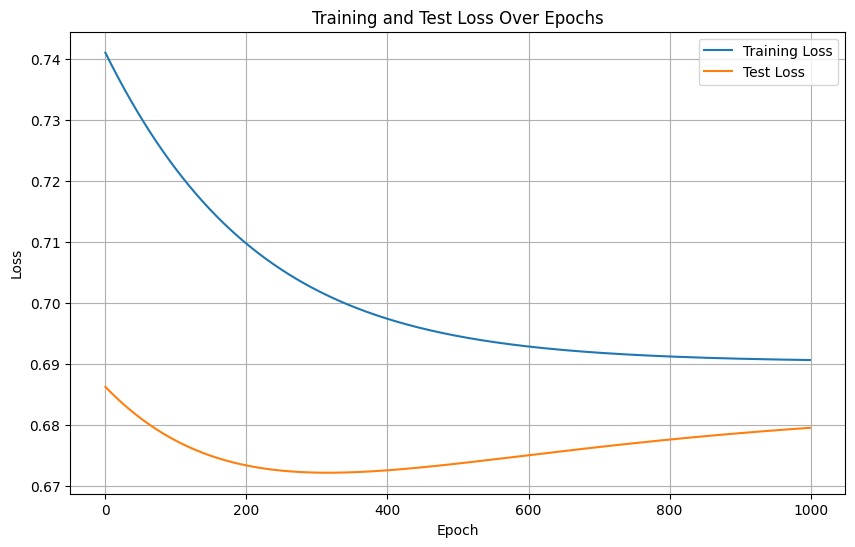

Training Accuracy: 0.5188 (51.88%)
Test Accuracy: 0.5250 (52.50%)


In [3]:
# Training parameters
num_epochs = 1000
train_losses = []
test_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

print("Training completed!")

# Plot training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
def evaluate_model(model, X, y, threshold=0.5):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        predicted_classes = (predictions >= threshold).float()
        accuracy = (predicted_classes == y).float().mean()
    return accuracy.item(), predictions, predicted_classes

train_accuracy, train_preds, train_pred_classes = evaluate_model(model, X_train_tensor, y_train_tensor)
test_accuracy, test_preds, test_pred_classes = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

In [4]:
# Reinitialize model with L2 regularization
model_l2 = LogisticRegressionModel(input_dim)
weight_decay = 0.01
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(f"Training model with L2 regularization (weight_decay={weight_decay})...")

# Training loop with L2 regularization
train_losses_l2 = []
test_losses_l2 = []

for epoch in range(num_epochs):
    model_l2.train()
    outputs = model_l2(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer_l2.zero_grad()
    loss.backward()
    optimizer_l2.step()

    train_losses_l2.append(loss.item())

    model_l2.eval()
    with torch.no_grad():
        test_outputs = model_l2(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses_l2.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

print("Training with L2 regularization completed!")

# Evaluate model with L2 regularization
train_accuracy_l2, train_preds_l2, _ = evaluate_model(model_l2, X_train_tensor, y_train_tensor)
test_accuracy_l2, test_preds_l2, test_pred_classes_l2 = evaluate_model(model_l2, X_test_tensor, y_test_tensor)

print(f"\nWith L2 Regularization (weight_decay={weight_decay}):")
print(f"Training Accuracy: {train_accuracy_l2:.4f} ({train_accuracy_l2*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy_l2:.4f} ({test_accuracy_l2*100:.2f}%)")

print(f"\nImprovement with L2 regularization:")
print(f"Training Accuracy: {train_accuracy_l2 - train_accuracy:+.4f}")
print(f"Test Accuracy: {test_accuracy_l2 - test_accuracy:+.4f}")

Training model with L2 regularization (weight_decay=0.01)...
Epoch [100/1000], Train Loss: 0.7196, Test Loss: 0.7125
Epoch [200/1000], Train Loss: 0.7079, Test Loss: 0.7018
Epoch [300/1000], Train Loss: 0.7008, Test Loss: 0.6952
Epoch [400/1000], Train Loss: 0.6966, Test Loss: 0.6911
Epoch [500/1000], Train Loss: 0.6940, Test Loss: 0.6886
Epoch [600/1000], Train Loss: 0.6925, Test Loss: 0.6870
Epoch [700/1000], Train Loss: 0.6916, Test Loss: 0.6860
Epoch [800/1000], Train Loss: 0.6911, Test Loss: 0.6853
Epoch [900/1000], Train Loss: 0.6908, Test Loss: 0.6848
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6845
Training with L2 regularization completed!

With L2 Regularization (weight_decay=0.01):
Training Accuracy: 0.5275 (52.75%)
Test Accuracy: 0.5550 (55.50%)

Improvement with L2 regularization:
Training Accuracy: +0.0087
Test Accuracy: +0.0300


CONFUSION MATRIX


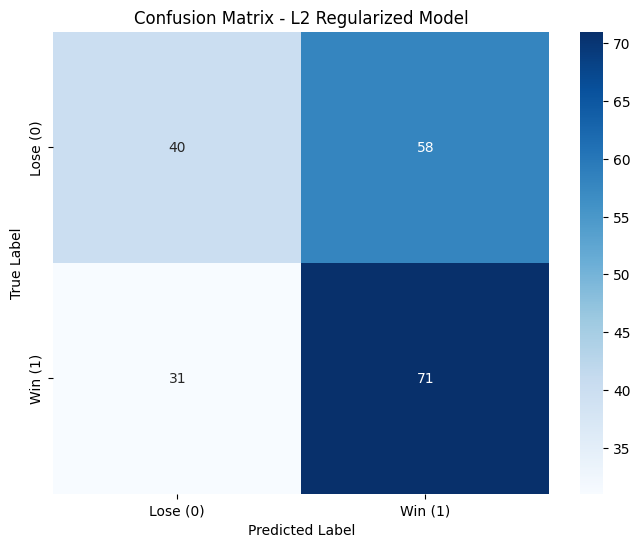

Accuracy: 0.5550
Precision: 0.5504
Recall: 0.6961
F1-Score: 0.6147

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Lose (0)       0.56      0.41      0.47        98
     Win (1)       0.55      0.70      0.61       102

    accuracy                           0.56       200
   macro avg       0.56      0.55      0.54       200
weighted avg       0.56      0.56      0.55       200


ROC CURVE ANALYSIS


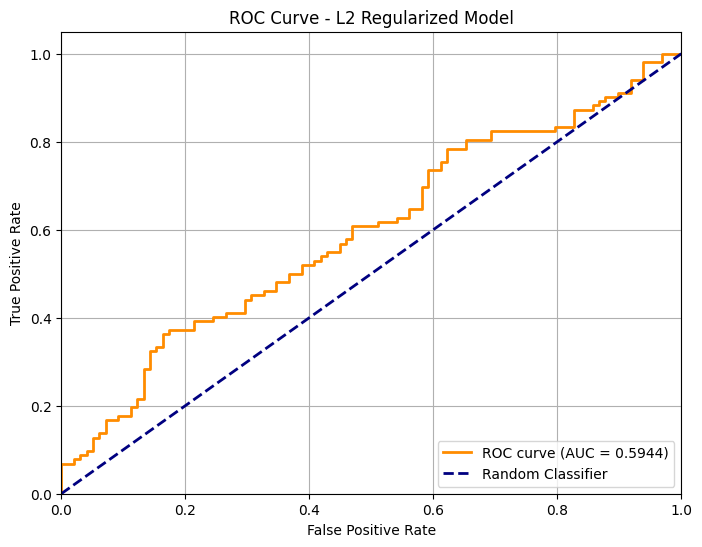

AUC Score: 0.5944


In [5]:
# Convert tensors to numpy for sklearn functions
y_test_np = y_test_tensor.numpy().flatten()
test_preds_np = test_preds_l2.numpy().flatten()
test_pred_classes_np = test_pred_classes_l2.numpy().flatten()

# 1. Confusion Matrix
print("=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

cm = confusion_matrix(y_test_np, test_pred_classes_np)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lose (0)', 'Win (1)'],
            yticklabels=['Lose (0)', 'Win (1)'])
plt.title('Confusion Matrix - L2 Regularized Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# 2. Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test_np, test_pred_classes_np,
                          target_names=['Lose (0)', 'Win (1)']))

# 3. ROC Curve
print("\n" + "=" * 60)
print("ROC CURVE ANALYSIS")
print("=" * 60)

fpr, tpr, thresholds = roc_curve(y_test_np, test_preds_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - L2 Regularized Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [6]:
# Save the trained model
model_path = 'league_of_legends_model.pth'
torch.save(model_l2.state_dict(), model_path)
print(f"Model saved to '{model_path}'")

# Create a new model instance and load the saved weights
loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded successfully!")

# Evaluate the loaded model
loaded_train_accuracy, _, _ = evaluate_model(loaded_model, X_train_tensor, y_train_tensor)
loaded_test_accuracy, _, _ = evaluate_model(loaded_model, X_test_tensor, y_test_tensor)

print(f"\nLoaded Model Performance:")
print(f"Training Accuracy: {loaded_train_accuracy:.4f} ({loaded_train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {loaded_test_accuracy:.4f} ({loaded_test_accuracy*100:.2f}%)")

# Verification
print(f"\nVerification (difference from original):")
print(f"Training Accuracy difference: {abs(train_accuracy_l2 - loaded_train_accuracy):.6f}")
print(f"Test Accuracy difference: {abs(test_accuracy_l2 - loaded_test_accuracy):.6f}")

if abs(test_accuracy_l2 - loaded_test_accuracy) < 0.0001:
    print("✓ Model loaded successfully and produces identical results!")
else:
    print("⚠ Small differences detected (could be due to floating point precision)")

Model saved to 'league_of_legends_model.pth'
Model loaded successfully!

Loaded Model Performance:
Training Accuracy: 0.5275 (52.75%)
Test Accuracy: 0.5550 (55.50%)

Verification (difference from original):
Training Accuracy difference: 0.000000
Test Accuracy difference: 0.000000
✓ Model loaded successfully and produces identical results!


HYPERPARAMETER TUNING - LEARNING RATE

Testing learning rate: 0.001
Test Accuracy: 0.4900 (49.00%)

Testing learning rate: 0.01
Test Accuracy: 0.5150 (51.50%)

Testing learning rate: 0.05
Test Accuracy: 0.5400 (54.00%)

Testing learning rate: 0.1
Test Accuracy: 0.5350 (53.50%)

Testing learning rate: 0.2
Test Accuracy: 0.5350 (53.50%)

TUNING RESULTS SUMMARY
LR: 0.001 -> Test Accuracy: 0.4900
LR: 0.010 -> Test Accuracy: 0.5150
LR: 0.050 -> Test Accuracy: 0.5400
LR: 0.100 -> Test Accuracy: 0.5350
LR: 0.200 -> Test Accuracy: 0.5350

✅ Best Learning Rate: 0.05
✅ Best Test Accuracy: 0.5400 (54.00%)


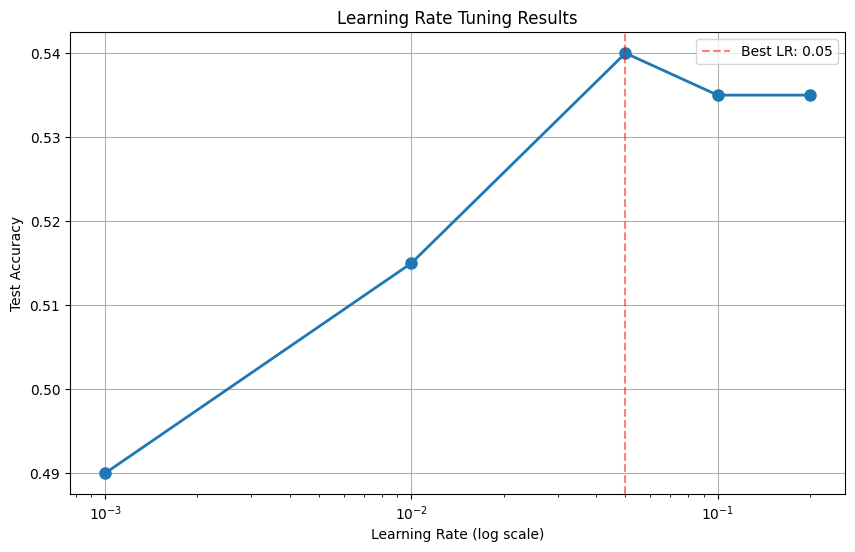

In [7]:
# Define learning rates to test
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2]
num_epochs_tuning = 500

best_lr = None
best_test_accuracy = 0
results = []

print("=" * 60)
print("HYPERPARAMETER TUNING - LEARNING RATE")
print("=" * 60)

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")

    # Reinitialize model for each learning rate
    model_tuning = LogisticRegressionModel(input_dim)
    optimizer_tuning = optim.SGD(model_tuning.parameters(), lr=lr, weight_decay=0.01)

    # Training loop
    for epoch in range(num_epochs_tuning):
        model_tuning.train()
        outputs = model_tuning(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer_tuning.zero_grad()
        loss.backward()
        optimizer_tuning.step()

    # Evaluate
    model_tuning.eval()
    with torch.no_grad():
        test_outputs = model_tuning(X_test_tensor)
        test_preds_tuning = (test_outputs >= 0.5).float()
        test_accuracy_tuning = (test_preds_tuning == y_test_tensor).float().mean().item()

    results.append((lr, test_accuracy_tuning))
    print(f"Test Accuracy: {test_accuracy_tuning:.4f} ({test_accuracy_tuning*100:.2f}%)")

    # Update best learning rate
    if test_accuracy_tuning > best_test_accuracy:
        best_test_accuracy = test_accuracy_tuning
        best_lr = lr

# Display tuning results
print("\n" + "=" * 60)
print("TUNING RESULTS SUMMARY")
print("=" * 60)
for lr, acc in results:
    print(f"LR: {lr:.3f} -> Test Accuracy: {acc:.4f}")

print(f"\n✅ Best Learning Rate: {best_lr}")
print(f"✅ Best Test Accuracy: {best_test_accuracy:.4f} ({best_test_accuracy*100:.2f}%)")

# Visualize results
plt.figure(figsize=(10, 6))
lrs, accs = zip(*results)
plt.plot(lrs, accs, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Test Accuracy')
plt.title('Learning Rate Tuning Results')
plt.grid(True)
plt.axvline(x=best_lr, color='r', linestyle='--', alpha=0.5, label=f'Best LR: {best_lr}')
plt.legend()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Top 10 most important features:
     Feature    Weight  Absolute_Weight
wards_placed  0.089531         0.089531
 gold_earned  0.069270         0.069270
damage_dealt -0.053402         0.053402
       kills  0.026650         0.026650
      deaths  0.011718         0.011718
          cs -0.006916         0.006916
wards_killed -0.002911         0.002911
     assists  0.000679         0.000679


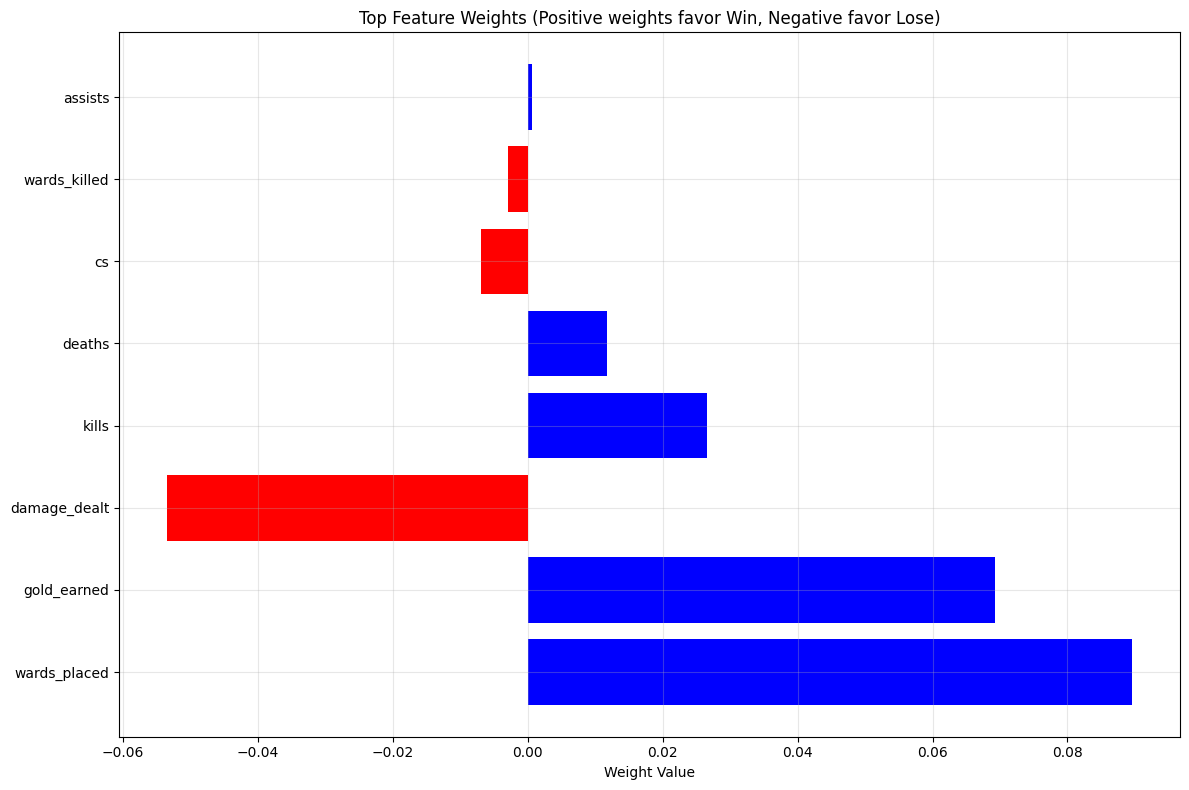

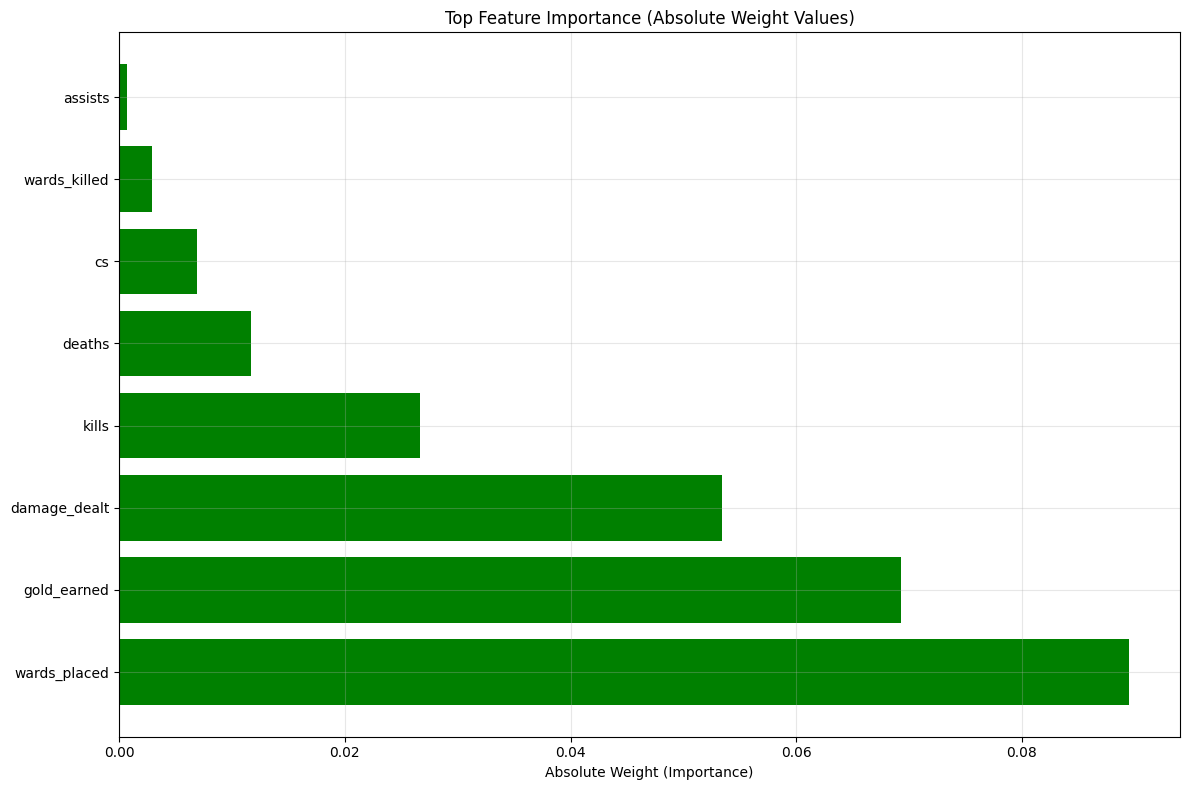


TOP 3 MOST IMPORTANT FEATURES
wards_placed: Weight = 0.0895 (impacts prediction positively)
gold_earned: Weight = 0.0693 (impacts prediction positively)
damage_dealt: Weight = -0.0534 (impacts prediction negatively)

PROJECT COMPLETED SUCCESSFULLY!
Summary of Results:
1. Test Accuracy (with L2): 0.5550 (55.50%)
2. Best Learning Rate: 0.05
3. AUC Score: 0.5944
4. Model saved to: 'league_of_legends_model.pth'
5. Top 3 Features: wards_placed, gold_earned, damage_dealt


In [8]:
# Extract weights from the trained model
weights = model_l2.linear.weight.data.numpy().flatten()

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Weight': weights,
    'Absolute_Weight': np.abs(weights)
})

# Sort by absolute weight (importance)
feature_importance = feature_importance.sort_values('Absolute_Weight', ascending=False)

print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)
print("\nTop 10 most important features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance (weights)
plt.figure(figsize=(12, 8))
top_n = min(15, len(feature_importance))
colors = ['red' if w < 0 else 'blue' for w in feature_importance['Weight'].head(top_n)]

plt.barh(range(top_n), feature_importance['Weight'].head(top_n), color=colors)
plt.yticks(range(top_n), feature_importance['Feature'].head(top_n))
plt.xlabel('Weight Value')
plt.title('Top Feature Weights (Positive weights favor Win, Negative favor Lose)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot absolute feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), feature_importance['Absolute_Weight'].head(top_n), color='green')
plt.yticks(range(top_n), feature_importance['Feature'].head(top_n))
plt.xlabel('Absolute Weight (Importance)')
plt.title('Top Feature Importance (Absolute Weight Values)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 3 most important features
print("\n" + "=" * 60)
print("TOP 3 MOST IMPORTANT FEATURES")
print("=" * 60)
top_features = feature_importance.head(3)
for idx, row in top_features.iterrows():
    direction = "positively" if row['Weight'] > 0 else "negatively"
    print(f"{row['Feature']}: Weight = {row['Weight']:.4f} (impacts prediction {direction})")

# Final summary
print("\n" + "=" * 60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("Summary of Results:")
print(f"1. Test Accuracy (with L2): {test_accuracy_l2:.4f} ({test_accuracy_l2*100:.2f}%)")
print(f"2. Best Learning Rate: {best_lr}")
print(f"3. AUC Score: {roc_auc:.4f}")
print(f"4. Model saved to: '{model_path}'")
print(f"5. Top 3 Features: {', '.join(feature_importance['Feature'].head(3).tolist())}")